##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# 加载和预处理图像

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/tutorials/load_data/images"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a>   </td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/load_data/images.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行 </a></td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/load_data/images.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看源代码</a>   </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/load_data/images.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a>   </td>
</table>

本教程介绍如何以三种方式加载和预处理图像数据集：

- 首先，您将使用高级 Keras 预处理效用函数（例如 `tf.keras.utils.image_dataset_from_directory`）和层（例如 `tf.keras.layers.Rescaling`）来读取磁盘上的图像目录。
- 然后，您将[使用 tf.data](../../guide/data.ipynb) 从头编写自己的输入流水线。
- 最后，您将从 [TensorFlow Datasets](https://tensorflow.google.cn/datasets) 中的大型[目录](https://tensorflow.google.cn/datasets/catalog/overview)下载数据集。

## 配置

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

2023-11-07 23:50:26.194954: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 23:50:26.195000: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 23:50:26.196749: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
print(tf.__version__)

2.15.0-rc1


### 检索图片

本教程使用一个包含数千张花卉照片的数据集。该花卉数据集包含 5 个子目录，每个子目录对应一个类：

```
flowers_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

注：所有图像均获得 CC-BY 许可，创作者在 LICENSE.txt 文件中列出。

In [4]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

     8192/228813984 [..............................] - ETA: 0s

  9510912/228813984 [>.............................] - ETA: 1s

 21258240/228813984 [=>............................] - ETA: 0s

 33021952/228813984 [===>..........................] - ETA: 0s

 43778048/228813984 [====>.........................] - ETA: 0s

 53411840/228813984 [======>.......................] - ETA: 0s

 63946752/228813984 [=======>......................] - ETA: 0s

 67117056/228813984 [=======>......................] - ETA: 1s

 79437824/228813984 [=========>....................] - ETA: 0s

 92717056/228813984 [===========>..................] - ETA: 0s

105742336/228813984 [============>.................] - ETA: 0s

109060096/228813984 [=============>................] - ETA: 0s

121454592/228813984 [==============>...............] - ETA: 0s

133881856/228813984 [================>.............] - ETA: 0s

146350080/228813984 [==================>...........] - ETA: 0s

159612928/228813984 [===================>..........] - ETA: 0s

172367872/228813984 [=====================>........] - ETA: 0s

180477952/228813984 [======================>.......] - ETA: 0s

190734336/228813984 [========================>.....] - ETA: 0s

199278592/228813984 [=========================>....] - ETA: 0s

211197952/228813984 [==========================>...] - ETA: 0s

222306304/228813984 [============================>.] - ETA: 0s

228813984/228813984 [==============================] - 1s 0us/step


下载 (218MB) 后，您现在应该拥有花卉照片的副本。总共有 3670 个图像：

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


每个目录都包含该类型花卉的图像。下面是一些玫瑰：

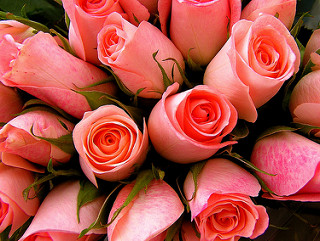

In [6]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

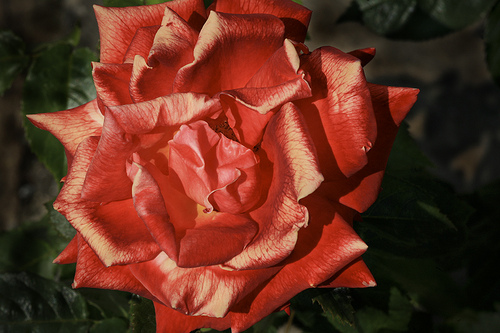

In [7]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

## 使用 Keras 效用函数加载数据

让我们使用实用的 `tf.keras.utils.image_dataset_from_directory` 效用函数从磁盘加载这些图像。

### 创建数据集

为加载器定义一些参数：

In [8]:
batch_size = 32
img_height = 180
img_width = 180

开发模型时，最好使用验证拆分。您将使用 80% 的图像进行训练，20% 的图像进行验证。

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.


Using 2936 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.


Using 734 files for validation.


您可以在这些数据集的 `class_names` 特性中找到类名称。

In [11]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### 呈现数据

下面是训练数据集中的前 9 个图像。

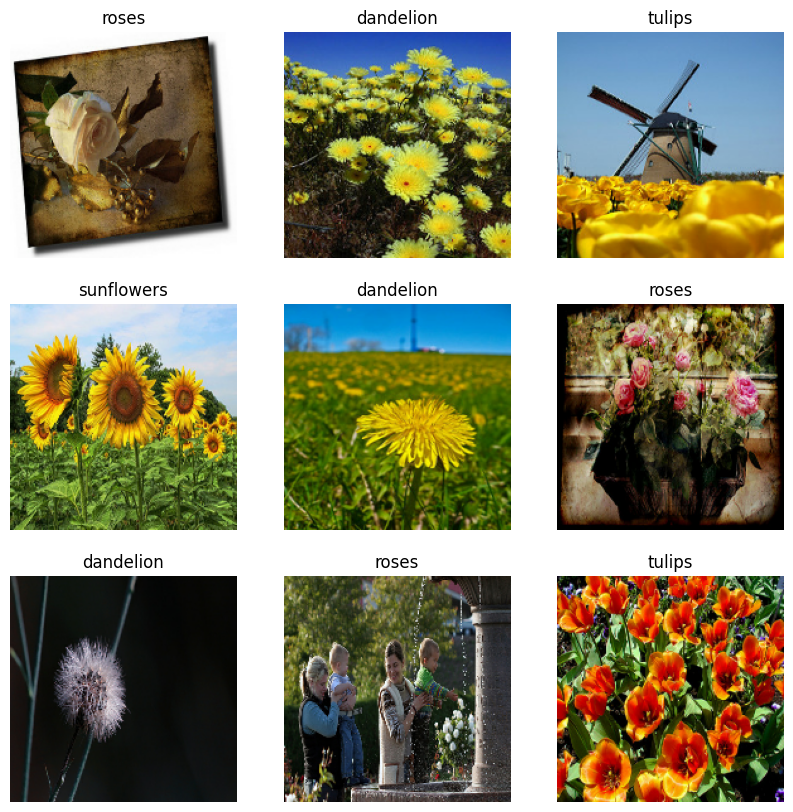

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

您可以使用这些数据集来训练模型，方法是将它们传递给 `model.fit`（在本教程后面展示）。如果愿意，您还可以手动迭代数据集并检索批量图像：

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


`image_batch` 是形状为 `(32, 180, 180, 3)` 的张量。这是由 32 个形状为 `180x180x3`（最后一个维度是指颜色通道 RGB）的图像组成的批次。`label_batch` 是形状为 `(32,)` 的张量，这些是 32 个图像的对应标签。

您可以对这些张量中的任何一个调用 `.numpy()` 以将它们转换为 `numpy.ndarray`。

### 标准化数据


RGB 通道值在 `[0, 255]` 范围内。这对于神经网络来说并不理想；一般而言，您应当设法使您的输入值变小。

在这里，我们通过使用 `tf.keras.layers.Rescaling` 将值标准化为在 `[0, 1]` 范围内。

In [14]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

可以通过两种方式使用该层。您可以通过调用 `Dataset.map` 将其应用于数据集：

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.96902645


或者，您也可以在模型定义中包含该层以简化部署。在这里，您将使用第二种方式。

注：如果您想将像素值缩放到 `[-1,1]`，则可以改为编写 `tf.keras.layers.Rescaling(1./127.5, offset=-1)`

注：您之前使用 `tf.keras.utils.image_dataset_from_directory` 的 `image_size` 参数调整了图像大小。如果您还希望在模型中包括调整大小的逻辑，可以使用 `tf.keras.layers.Resizing` 层。

### 配置数据集以提高性能

我们确保使用缓冲预获取，以便您可以从磁盘生成数据，而不会导致 I/O 阻塞。下面是加载数据时应当使用的两个重要方法。

- 在第一个周期期间从磁盘加载图像后，`Dataset.cache()` 会将这些图像保留在内存中。这将确保在训练模型时数据集不会成为瓶颈。如果数据集太大无法装入内存，您也可以使用此方法创建高性能的磁盘缓存。
- `Dataset.prefetch()` 会在训练时将数据预处理和模型执行重叠。

感兴趣的读者可以在<a>使用 tf.data API 提升性能</a>指南的<em>预提取</em>部分了解更多有关这两种方法的详细信息，以及如何将数据缓存到磁盘。

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 训练模型

为了完整起见，您现在将使用刚刚准备的数据集来训练一个简单模型。

[序贯](https://tensorflow.google.cn/guide/keras/sequential_model)模型由三个卷积块 (`tf.keras.layers.Conv2D`) 组成，每个卷积块都有一个最大池化层 (`tf.keras.layers.MaxPooling2D`)。有一个全连接层 (`tf.keras.layers.Dense`)，上面有 128 个单元，由 ReLU 激活函数 (`'relu'`) 激活。此模型尚未进行任何调整（目标是使用您刚刚创建的数据集展示机制）。要详细了解图像分类，请访问[图像分类](../images/classification.ipynb)教程。

In [17]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

选择 `tf.keras.optimizers.Adam` 优化器和 `tf.keras.losses.SparseCategoricalCrossentropy` 损失函数。要查看每个训练周期的训练和验证准确率，请将 `metrics` 参数传递给 `Model.compile`。

In [18]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

注：您将仅训练几个周期，因此本教程的运行速度很快。 

In [19]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3


I0000 00:00:1699401037.572424  576366 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 1/92 [..............................] - ETA: 5:42 - loss: 1.6271 - accuracy: 0.1562

 4/92 [>.............................] - ETA: 1s - loss: 1.7496 - accuracy: 0.2031  

 7/92 [=>............................] - ETA: 1s - loss: 1.7133 - accuracy: 0.2143

10/92 [==>...........................] - ETA: 1s - loss: 1.6683 - accuracy: 0.2094

13/92 [===>..........................] - ETA: 1s - loss: 1.6201 - accuracy: 0.2404

16/92 [====>.........................] - ETA: 1s - loss: 1.5794 - accuracy: 0.2656

19/92 [=====>........................] - ETA: 1s - loss: 1.5574 - accuracy: 0.2763

22/92 [======>.......................] - ETA: 1s - loss: 1.5291 - accuracy: 0.2955

25/92 [=======>......................] - ETA: 1s - loss: 1.5181 - accuracy: 0.3088

28/92 [========>.....................] - ETA: 1s - loss: 1.4975 - accuracy: 0.3225

31/92 [=========>....................] - ETA: 1s - loss: 1.4934 - accuracy: 0.3286

34/92 [==========>...................] - ETA: 1s - loss: 1.4656 - accuracy: 0.3447

37/92 [===========>..................] - ETA: 1s - loss: 1.4402 - accuracy: 0.3564

40/92 [============>.................] - ETA: 1s - loss: 1.4267 - accuracy: 0.3641

43/92 [=============>................] - ETA: 1s - loss: 1.4032 - accuracy: 0.3757

46/92 [==============>...............] - ETA: 0s - loss: 1.3982 - accuracy: 0.3804

49/92 [==============>...............] - ETA: 0s - loss: 1.3945 - accuracy: 0.3814

52/92 [===============>..............] - ETA: 0s - loss: 1.3878 - accuracy: 0.3834

55/92 [================>.............] - ETA: 0s - loss: 1.3767 - accuracy: 0.3892

58/92 [=================>............] - ETA: 0s - loss: 1.3837 - accuracy: 0.3874

61/92 [==================>...........] - ETA: 0s - loss: 1.3730 - accuracy: 0.3970

64/92 [===================>..........] - ETA: 0s - loss: 1.3648 - accuracy: 0.4014

67/92 [====================>.........] - ETA: 0s - loss: 1.3524 - accuracy: 0.4076

70/92 [=====================>........] - ETA: 0s - loss: 1.3506 - accuracy: 0.4067

73/92 [======================>.......] - ETA: 0s - loss: 1.3364 - accuracy: 0.4118

76/92 [=======================>......] - ETA: 0s - loss: 1.3373 - accuracy: 0.4132

79/92 [========================>.....] - ETA: 0s - loss: 1.3328 - accuracy: 0.4150

82/92 [=========================>....] - ETA: 0s - loss: 1.3311 - accuracy: 0.4165

85/92 [==========================>...] - ETA: 0s - loss: 1.3273 - accuracy: 0.4154

88/92 [===========================>..] - ETA: 0s - loss: 1.3251 - accuracy: 0.4187

91/92 [============================>.] - ETA: 0s - loss: 1.3278 - accuracy: 0.4207

92/92 [==============================] - ETA: 0s - loss: 1.3283 - accuracy: 0.4206

92/92 [==============================] - 7s 40ms/step - loss: 1.3283 - accuracy: 0.4206 - val_loss: 1.1287 - val_accuracy: 0.5790


Epoch 2/3


 1/92 [..............................] - ETA: 2s - loss: 1.1374 - accuracy: 0.6250

 4/92 [>.............................] - ETA: 1s - loss: 1.0349 - accuracy: 0.6250

 7/92 [=>............................] - ETA: 1s - loss: 1.1055 - accuracy: 0.5804

10/92 [==>...........................] - ETA: 1s - loss: 1.0812 - accuracy: 0.5781

13/92 [===>..........................] - ETA: 1s - loss: 1.0763 - accuracy: 0.5625

16/92 [====>.........................] - ETA: 1s - loss: 1.0560 - accuracy: 0.5762

19/92 [=====>........................] - ETA: 1s - loss: 1.0558 - accuracy: 0.5641

22/92 [======>.......................] - ETA: 1s - loss: 1.0351 - accuracy: 0.5724

25/92 [=======>......................] - ETA: 1s - loss: 1.0668 - accuracy: 0.5725

28/92 [========>.....................] - ETA: 1s - loss: 1.0611 - accuracy: 0.5826

31/92 [=========>....................] - ETA: 1s - loss: 1.0661 - accuracy: 0.5817

34/92 [==========>...................] - ETA: 1s - loss: 1.0573 - accuracy: 0.5800

37/92 [===========>..................] - ETA: 1s - loss: 1.0450 - accuracy: 0.5878

40/92 [============>.................] - ETA: 1s - loss: 1.0395 - accuracy: 0.5906

43/92 [=============>................] - ETA: 1s - loss: 1.0355 - accuracy: 0.5916

46/92 [==============>...............] - ETA: 0s - loss: 1.0437 - accuracy: 0.5883

49/92 [==============>...............] - ETA: 0s - loss: 1.0500 - accuracy: 0.5829

52/92 [===============>..............] - ETA: 0s - loss: 1.0536 - accuracy: 0.5835

55/92 [================>.............] - ETA: 0s - loss: 1.0519 - accuracy: 0.5847

58/92 [=================>............] - ETA: 0s - loss: 1.0602 - accuracy: 0.5803

61/92 [==================>...........] - ETA: 0s - loss: 1.0553 - accuracy: 0.5866

64/92 [===================>..........] - ETA: 0s - loss: 1.0481 - accuracy: 0.5918

67/92 [====================>.........] - ETA: 0s - loss: 1.0425 - accuracy: 0.5942

70/92 [=====================>........] - ETA: 0s - loss: 1.0472 - accuracy: 0.5911

73/92 [======================>.......] - ETA: 0s - loss: 1.0384 - accuracy: 0.5955

76/92 [=======================>......] - ETA: 0s - loss: 1.0431 - accuracy: 0.5954

79/92 [========================>.....] - ETA: 0s - loss: 1.0437 - accuracy: 0.5930

82/92 [=========================>....] - ETA: 0s - loss: 1.0455 - accuracy: 0.5930

85/92 [==========================>...] - ETA: 0s - loss: 1.0464 - accuracy: 0.5908

88/92 [===========================>..] - ETA: 0s - loss: 1.0484 - accuracy: 0.5902

91/92 [============================>.] - ETA: 0s - loss: 1.0559 - accuracy: 0.5872

92/92 [==============================] - 2s 24ms/step - loss: 1.0565 - accuracy: 0.5869 - val_loss: 1.0236 - val_accuracy: 0.6281


Epoch 3/3


 1/92 [..............................] - ETA: 1s - loss: 0.9840 - accuracy: 0.5938

 4/92 [>.............................] - ETA: 1s - loss: 0.8953 - accuracy: 0.6562

 7/92 [=>............................] - ETA: 1s - loss: 0.9496 - accuracy: 0.6473

10/92 [==>...........................] - ETA: 1s - loss: 0.9275 - accuracy: 0.6531

13/92 [===>..........................] - ETA: 1s - loss: 0.9369 - accuracy: 0.6370

16/92 [====>.........................] - ETA: 1s - loss: 0.9169 - accuracy: 0.6465

19/92 [=====>........................] - ETA: 1s - loss: 0.9110 - accuracy: 0.6398

22/92 [======>.......................] - ETA: 1s - loss: 0.8871 - accuracy: 0.6506

25/92 [=======>......................] - ETA: 1s - loss: 0.9079 - accuracy: 0.6525

28/92 [========>.....................] - ETA: 1s - loss: 0.9021 - accuracy: 0.6585

31/92 [=========>....................] - ETA: 1s - loss: 0.9125 - accuracy: 0.6522

34/92 [==========>...................] - ETA: 1s - loss: 0.9079 - accuracy: 0.6498

37/92 [===========>..................] - ETA: 1s - loss: 0.9046 - accuracy: 0.6529

40/92 [============>.................] - ETA: 1s - loss: 0.9066 - accuracy: 0.6516

43/92 [=============>................] - ETA: 1s - loss: 0.9010 - accuracy: 0.6541

46/92 [==============>...............] - ETA: 0s - loss: 0.9051 - accuracy: 0.6508

49/92 [==============>...............] - ETA: 0s - loss: 0.9078 - accuracy: 0.6467

52/92 [===============>..............] - ETA: 0s - loss: 0.9138 - accuracy: 0.6436

55/92 [================>.............] - ETA: 0s - loss: 0.9105 - accuracy: 0.6449

58/92 [=================>............] - ETA: 0s - loss: 0.9154 - accuracy: 0.6428

61/92 [==================>...........] - ETA: 0s - loss: 0.9104 - accuracy: 0.6491

64/92 [===================>..........] - ETA: 0s - loss: 0.9022 - accuracy: 0.6553

67/92 [====================>.........] - ETA: 0s - loss: 0.8937 - accuracy: 0.6595

70/92 [=====================>........] - ETA: 0s - loss: 0.8949 - accuracy: 0.6598

73/92 [======================>.......] - ETA: 0s - loss: 0.8893 - accuracy: 0.6627

76/92 [=======================>......] - ETA: 0s - loss: 0.8908 - accuracy: 0.6632

79/92 [========================>.....] - ETA: 0s - loss: 0.8895 - accuracy: 0.6622

82/92 [=========================>....] - ETA: 0s - loss: 0.8884 - accuracy: 0.6631

85/92 [==========================>...] - ETA: 0s - loss: 0.8891 - accuracy: 0.6632

88/92 [===========================>..] - ETA: 0s - loss: 0.8893 - accuracy: 0.6630

91/92 [============================>.] - ETA: 0s - loss: 0.8934 - accuracy: 0.6607

92/92 [==============================] - 2s 24ms/step - loss: 0.8921 - accuracy: 0.6608 - val_loss: 0.9263 - val_accuracy: 0.6512


注：您也可以编写自定义训练循环而不是使用 `Model.fit`。要了解详情，请访问[从头编写训练循环](https://tensorflow.google.cn/guide/keras/writing_a_training_loop_from_scratch)教程。

您可能会注意到，与训练准确率相比，验证准确率较低，这表明我们的模型存在过拟合。您可以在此[教程](https://tensorflow.google.cn/tutorials/keras/overfit_and_underfit)中详细了解过拟合以及如何减少过拟合。

## 使用 tf.data 进行更精细的控制

利用上面的 Keras 预处理效用函数 `tf.keras.utils.image_dataset_from_directory`，可以方便地从头创建 `tf.data.Dataset`。

要实现更精细的控制，您可以使用 <code>tf.data</code> 编写自己的输入流水线。本部分展示了如何做到这一点，从我们之前下载的 TGZ 文件中的文件路径开始。

In [20]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [21]:
for f in list_ds.take(5):
  print(f.numpy())

b'/home/kbuilder/.keras/datasets/flower_photos/daisy/2454280135_ac3aa75cdc_n.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/dandelion/7267547016_c8903920bf.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/daisy/7924174040_444d5bbb8a.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/tulips/6958342976_a4a9483488_n.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/roses/1392579828_ab5a139052.jpg'


文件的树结构可用于编译 `class_names` 列表。

In [22]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


将数据集拆分为训练集和测试集：

In [23]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

您可以按照如下方式打印每个数据集的长度：

In [24]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


编写一个将文件路径转换为 `(img, label)` 对的短函数：

In [25]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [26]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [27]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

使用 `Dataset.map` 创建 `image, label` 对的数据集：

In [28]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [29]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  0


### 训练的基本方法

要使用此数据集训练模型，你将会想要数据：

- 被充分打乱。
- 被分割为 batch。
- 永远重复。

使用 `tf.data` API 可以轻松添加这些功能。有关详情，请访问[输入流水线性能](../../guide/performance/datasets.ipynb)指南。

In [30]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

### 呈现数据

您可以通过与之前创建的数据集类似的方式呈现此数据集：

2023-11-07 23:50:47.880053: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


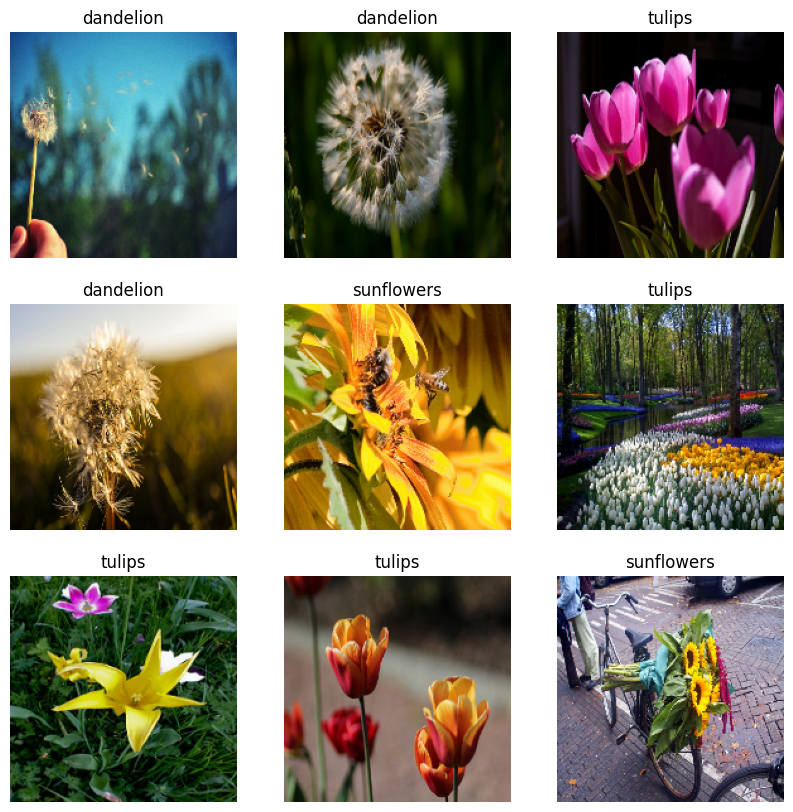

In [31]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

### 继续训练模型

您现在已经手动构建了一个与由上面的 `keras.preprocessing` 创建的数据集类似的 `tf.data.Dataset`。您可以继续用它来训练模型。和之前一样，您将只训练几个周期以确保较短的运行时间。

In [32]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3


 1/92 [..............................] - ETA: 47s - loss: 0.8894 - accuracy: 0.6562

 3/92 [..............................] - ETA: 2s - loss: 0.8340 - accuracy: 0.7188 

 5/92 [>.............................] - ETA: 2s - loss: 0.7205 - accuracy: 0.7563

 7/92 [=>............................] - ETA: 2s - loss: 0.7920 - accuracy: 0.7188

 9/92 [=>............................] - ETA: 2s - loss: 0.7776 - accuracy: 0.7118

11/92 [==>...........................] - ETA: 2s - loss: 0.7836 - accuracy: 0.7045

14/92 [===>..........................] - ETA: 2s - loss: 0.7671 - accuracy: 0.7121

17/92 [====>.........................] - ETA: 1s - loss: 0.7947 - accuracy: 0.7004

20/92 [=====>........................] - ETA: 1s - loss: 0.7890 - accuracy: 0.6969

23/92 [======>.......................] - ETA: 1s - loss: 0.7752 - accuracy: 0.7024

26/92 [=======>......................] - ETA: 1s - loss: 0.7748 - accuracy: 0.7019

29/92 [========>.....................] - ETA: 1s - loss: 0.7536 - accuracy: 0.7144

32/92 [=========>....................] - ETA: 1s - loss: 0.7414 - accuracy: 0.7168

35/92 [==========>...................] - ETA: 1s - loss: 0.7486 - accuracy: 0.7152

38/92 [===========>..................] - ETA: 1s - loss: 0.7394 - accuracy: 0.7220

41/92 [============>.................] - ETA: 1s - loss: 0.7486 - accuracy: 0.7149

44/92 [=============>................] - ETA: 1s - loss: 0.7510 - accuracy: 0.7131

47/92 [==============>...............] - ETA: 1s - loss: 0.7521 - accuracy: 0.7101

50/92 [===============>..............] - ETA: 0s - loss: 0.7487 - accuracy: 0.7119

53/92 [================>.............] - ETA: 0s - loss: 0.7461 - accuracy: 0.7140

56/92 [=================>............] - ETA: 0s - loss: 0.7473 - accuracy: 0.7154

59/92 [==================>...........] - ETA: 0s - loss: 0.7509 - accuracy: 0.7140

62/92 [===================>..........] - ETA: 0s - loss: 0.7493 - accuracy: 0.7162

65/92 [====================>.........] - ETA: 0s - loss: 0.7460 - accuracy: 0.7183

68/92 [=====================>........] - ETA: 0s - loss: 0.7428 - accuracy: 0.7206

71/92 [======================>.......] - ETA: 0s - loss: 0.7411 - accuracy: 0.7218

74/92 [=======================>......] - ETA: 0s - loss: 0.7367 - accuracy: 0.7255

77/92 [========================>.....] - ETA: 0s - loss: 0.7414 - accuracy: 0.7216

80/92 [=========================>....] - ETA: 0s - loss: 0.7436 - accuracy: 0.7195

83/92 [==========================>...] - ETA: 0s - loss: 0.7401 - accuracy: 0.7206

86/92 [===========================>..] - ETA: 0s - loss: 0.7441 - accuracy: 0.7202

89/92 [============================>.] - ETA: 0s - loss: 0.7464 - accuracy: 0.7188

92/92 [==============================] - ETA: 0s - loss: 0.7457 - accuracy: 0.7183

92/92 [==============================] - 3s 28ms/step - loss: 0.7457 - accuracy: 0.7183 - val_loss: 0.7620 - val_accuracy: 0.7016


Epoch 2/3


 1/92 [..............................] - ETA: 2s - loss: 0.5767 - accuracy: 0.7812

 4/92 [>.............................] - ETA: 1s - loss: 0.6947 - accuracy: 0.7422

 7/92 [=>............................] - ETA: 1s - loss: 0.5867 - accuracy: 0.7991

10/92 [==>...........................] - ETA: 1s - loss: 0.5713 - accuracy: 0.7969

13/92 [===>..........................] - ETA: 1s - loss: 0.5804 - accuracy: 0.7885

16/92 [====>.........................] - ETA: 1s - loss: 0.5559 - accuracy: 0.7988

19/92 [=====>........................] - ETA: 1s - loss: 0.5544 - accuracy: 0.7928

22/92 [======>.......................] - ETA: 1s - loss: 0.5491 - accuracy: 0.8011

25/92 [=======>......................] - ETA: 1s - loss: 0.5626 - accuracy: 0.8025

28/92 [========>.....................] - ETA: 1s - loss: 0.5687 - accuracy: 0.7991

31/92 [=========>....................] - ETA: 1s - loss: 0.5621 - accuracy: 0.8004

34/92 [==========>...................] - ETA: 1s - loss: 0.5446 - accuracy: 0.8097

37/92 [===========>..................] - ETA: 1s - loss: 0.5428 - accuracy: 0.8091

40/92 [============>.................] - ETA: 1s - loss: 0.5393 - accuracy: 0.8102

43/92 [=============>................] - ETA: 1s - loss: 0.5437 - accuracy: 0.8060

46/92 [==============>...............] - ETA: 0s - loss: 0.5560 - accuracy: 0.8043

49/92 [==============>...............] - ETA: 0s - loss: 0.5536 - accuracy: 0.8042

52/92 [===============>..............] - ETA: 0s - loss: 0.5497 - accuracy: 0.8059

55/92 [================>.............] - ETA: 0s - loss: 0.5545 - accuracy: 0.8040

58/92 [=================>............] - ETA: 0s - loss: 0.5567 - accuracy: 0.8023

61/92 [==================>...........] - ETA: 0s - loss: 0.5591 - accuracy: 0.8012

64/92 [===================>..........] - ETA: 0s - loss: 0.5504 - accuracy: 0.8062

67/92 [====================>.........] - ETA: 0s - loss: 0.5479 - accuracy: 0.8074

70/92 [=====================>........] - ETA: 0s - loss: 0.5514 - accuracy: 0.8054

73/92 [======================>.......] - ETA: 0s - loss: 0.5525 - accuracy: 0.8044

76/92 [=======================>......] - ETA: 0s - loss: 0.5527 - accuracy: 0.8030

79/92 [========================>.....] - ETA: 0s - loss: 0.5478 - accuracy: 0.8038

82/92 [=========================>....] - ETA: 0s - loss: 0.5482 - accuracy: 0.8030

85/92 [==========================>...] - ETA: 0s - loss: 0.5458 - accuracy: 0.8033

88/92 [===========================>..] - ETA: 0s - loss: 0.5502 - accuracy: 0.8026

91/92 [============================>.] - ETA: 0s - loss: 0.5517 - accuracy: 0.8012

92/92 [==============================] - 2s 24ms/step - loss: 0.5508 - accuracy: 0.8014 - val_loss: 0.8038 - val_accuracy: 0.6935


Epoch 3/3


 1/92 [..............................] - ETA: 2s - loss: 0.4067 - accuracy: 0.9062

 4/92 [>.............................] - ETA: 1s - loss: 0.4361 - accuracy: 0.8672

 7/92 [=>............................] - ETA: 1s - loss: 0.4906 - accuracy: 0.8348

10/92 [==>...........................] - ETA: 1s - loss: 0.4310 - accuracy: 0.8625

13/92 [===>..........................] - ETA: 1s - loss: 0.4034 - accuracy: 0.8726

16/92 [====>.........................] - ETA: 1s - loss: 0.4083 - accuracy: 0.8672

19/92 [=====>........................] - ETA: 1s - loss: 0.4022 - accuracy: 0.8717

22/92 [======>.......................] - ETA: 1s - loss: 0.4252 - accuracy: 0.8636

25/92 [=======>......................] - ETA: 1s - loss: 0.4149 - accuracy: 0.8700

28/92 [========>.....................] - ETA: 1s - loss: 0.4126 - accuracy: 0.8705

31/92 [=========>....................] - ETA: 1s - loss: 0.4143 - accuracy: 0.8700

34/92 [==========>...................] - ETA: 1s - loss: 0.4116 - accuracy: 0.8732

37/92 [===========>..................] - ETA: 1s - loss: 0.4131 - accuracy: 0.8725

40/92 [============>.................] - ETA: 1s - loss: 0.4131 - accuracy: 0.8687

43/92 [=============>................] - ETA: 1s - loss: 0.4199 - accuracy: 0.8648

46/92 [==============>...............] - ETA: 0s - loss: 0.4099 - accuracy: 0.8682

49/92 [==============>...............] - ETA: 0s - loss: 0.4106 - accuracy: 0.8667

52/92 [===============>..............] - ETA: 0s - loss: 0.4043 - accuracy: 0.8696

55/92 [================>.............] - ETA: 0s - loss: 0.4050 - accuracy: 0.8682

58/92 [=================>............] - ETA: 0s - loss: 0.3996 - accuracy: 0.8707

61/92 [==================>...........] - ETA: 0s - loss: 0.3972 - accuracy: 0.8709

64/92 [===================>..........] - ETA: 0s - loss: 0.3964 - accuracy: 0.8691

67/92 [====================>.........] - ETA: 0s - loss: 0.4016 - accuracy: 0.8675

70/92 [=====================>........] - ETA: 0s - loss: 0.3998 - accuracy: 0.8674

73/92 [======================>.......] - ETA: 0s - loss: 0.3996 - accuracy: 0.8673

76/92 [=======================>......] - ETA: 0s - loss: 0.3974 - accuracy: 0.8680

79/92 [========================>.....] - ETA: 0s - loss: 0.3957 - accuracy: 0.8679

82/92 [=========================>....] - ETA: 0s - loss: 0.3945 - accuracy: 0.8689

85/92 [==========================>...] - ETA: 0s - loss: 0.3930 - accuracy: 0.8691

88/92 [===========================>..] - ETA: 0s - loss: 0.3887 - accuracy: 0.8711

91/92 [============================>.] - ETA: 0s - loss: 0.3854 - accuracy: 0.8723

92/92 [==============================] - 2s 24ms/step - loss: 0.3845 - accuracy: 0.8726 - val_loss: 0.7386 - val_accuracy: 0.7302


## 使用 TensorFlow Datasets

到目前为止，本教程的重点是从磁盘加载数据。此外，您还可以通过在 [TensorFlow Datasets](https://tensorflow.google.cn/datasets/catalog/overview) 上探索易于下载的大型数据集[目录](https://tensorflow.google.cn/datasets)来查找要使用的数据集。

由于您之前已经从磁盘加载了花卉数据集，接下来看看如何使用 TensorFlow Datasets 导入它。

使用 TensorFlow Datasets 下载花卉[数据集](https://tensorflow.google.cn/datasets/catalog/tf_flowers)：

In [33]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

花卉数据集有五个类：

In [34]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


从数据集中检索图像：

2023-11-07 23:50:58.052308: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


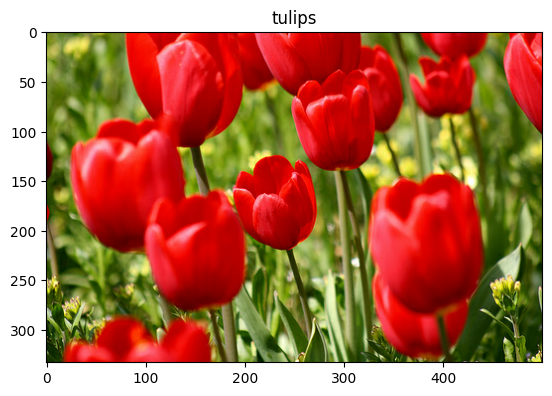

In [35]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

和以前一样，请记得对训练集、验证集和测试集进行批处理、打乱顺序和配置以提高性能。

In [36]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

您可以通过访问[数据增强](../images/data_augmentation.ipynb)教程找到使用花卉数据集和 TensorFlow Datasets 的完整示例。

## 后续步骤

本教程展示了从磁盘加载图像的两种方式。首先，您学习了如何使用 Keras 预处理层和效用函数加载和预处理图像数据集。接下来，您学习了如何使用 `tf.data` 从头开始编写输入流水线。最后，您学习了如何从 TensorFlow Datasets 下载数据集。

后续步骤：

- 您可以学习[如何添加数据增强](https://tensorflow.google.cn/tutorials/images/data_augmentation)。
- 要详细了解 `tf.data`，您可以访问 [tf.data：构建 TensorFlow 输入流水线](https://tensorflow.google.cn/guide/data)指南。